In [1]:
#  Games Played Linear Regression.ipynb - Baseball demonstration of linar regression.
#     Copyright (C) 2020  Geoffrey G. Messier
# 
#     This program is free software: you can redistribute it and/or modify
#     it under the terms of the GNU General Public License as published by
#     the Free Software Foundation, either version 3 of the License, or
#     (at your option) any later version.
# 
#     This program is distributed in the hope that it will be useful,
#     but WITHOUT ANY WARRANTY; without even the implied warranty of
#     MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#     GNU General Public License for more details.
# 
#     You should have received a copy of the GNU General Public License
#     along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [2]:
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy as sci
import scipy.special as scisp
import scipy.stats as scist
import datetime, copy, imp
import re
import sys
import numexpr as ne
import random

from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score 
from sklearn import linear_model
import statsmodels.api as sm

import MySQLdb

import pymysql.cursors;

from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D

tqdm.pandas()
plt.ion()

In [3]:
players = pd.read_hdf('~/data/baseball/PlayerSummary-2018.hdf',key='Data')
players

,Position,GamesPlayed,AtBats,AvgOuts,AvgOnBase,AvgRuns,AvgRbis
PlayerId,,,,,,,
abrej003,FirstBase,129,549,7.139535,0.327869,0.123862,0.078324
acunr001,LeftField,111,484,1.657658,0.367769,0.161157,0.070248
adaml001,LeftField,24,28,0.375000,0.357143,0.357143,0.142857
adamm002,FirstBase,117,332,3.658120,0.313253,0.126506,0.108434
adamw002,ShortStop,85,320,2.882353,0.350000,0.134375,0.059375
...,...,...,...,...,...,...,...
zimmb001,CenterField,36,114,2.277778,0.280702,0.122807,0.052632
zimmj003,Pitcher,2,2,0.000000,0.000000,0.000000,0.000000
zimmr001,FirstBase,85,318,6.541176,0.342767,0.103774,0.103774


In [4]:
nPlayers = len(players.index)
pct70 = players.GamesPlayed.sort_values().iloc[int(0.3*nPlayers)]
players70 = players[players.GamesPlayed >= pct70]

## Theory and Notation

- Let the $M \times (P+1)$ input data matrix $\mathbb{X} = [\ \mathbb{X}_0\ \mathbb{X}_1\ \ldots\ \mathbb{X}_p\ ]$, where $M$ is the number of training samples, $P$ is the number of data features and $\mathbb{X}_0$ is a column of 1's.
- This makes the linear hypothesis function equal to $\hat{\mathbb{Y}} = \mathbb{X}\mathbb{\beta}$.
- The sum of squares function and its derivatives:
\begin{equation*}
\begin{array}{c}
J(\beta) = (\mathbb{Y} - \mathbb{X}\beta)^T(\mathbb{Y} - \mathbb{X}\beta) \\
\delta J/ \delta\beta = - 2\mathbb{X}^T(\mathbb{Y} - \mathbb{X}\beta) \\
\delta^2 J/ (\delta\beta\delta\beta^T) = 2\mathbb{X}^T \mathbb{X} \\
\end{array}
\end{equation*}



## Direct Least Squares Coefficient Calculation
- The least square solution for the coefficients is found by setting the first derivative of $J(\beta)$ to zero and solving for $\beta$.  The result is $\hat{\beta} = \left(\mathbb{X}^T\mathbb{X}\right)^{-1}\mathbb{X}^T\mathbb{Y}$.
- If this calculation is too expensive, iterative methods like gradient descent can be used to solve for the model coefficients.

In [5]:
m = len(players70.index)
p = 4

# Target variable
y = np.array([ players70.GamesPlayed ]).transpose()

# Input variables (p=4 features)
x = np.ones((m,p+1))
x[:,1:] = players70[['AvgOuts','AvgOnBase','AvgRuns','AvgRbis']].to_numpy()
#x[:,1:] = players70[['AvgOuts','AvgOnBase']].to_numpy()
#x[:,1:] = players70[['AtBats']].to_numpy()

In [6]:
nrm = np.ones((1,p+1))
nrm[0,1:] = np.sqrt(x[:,1:].var(axis=0))
x = x/nrm

In [7]:
# Direct least squares calculation
betaLs = np.linalg.inv(x.T @ x) @ x.T @ y
yHat = x @ betaLs
betaLs

array([[-19.98833285],
       [ 14.15212167],
       [ 23.91125286],
       [ -0.78502377],
       [  2.51856959]])

In [8]:
# Z-score calculation
# - Scores greater than ~2 are significant at the 5% level.
varYHat = (y-yHat).var()
vs = np.linalg.inv( x.T @ x ).diagonal()
zScoreLs = np.abs( betaLs.T / np.sqrt( varYHat * vs ) )
degFreedom = m - p - 1
pVals = 1-scist.t.cdf(zScoreLs,degFreedom)

print('VarYHat: ', varYHat )
print('Z-Scores: ', zScoreLs )
print('P-Values: ', pVals )

VarYHat:  1449.8866523323609
Z-Scores:  [[ 4.09089264  8.69304716 11.55411656  0.46225475  1.46177651]]
P-Values:  [[2.40150055e-05 0.00000000e+00 0.00000000e+00 3.22021973e-01
  7.21282056e-02]]


These results suggest that we should be able to drop the average number of runs and RBIs without significantly affecting model accuracy.  More thoughtful techniques for adjusting/removing coefficients include subset discovery, Lasso and LAR.

## scikit Implementation

In [9]:
reg = linear_model.LinearRegression()
reg.fit(x,y)

LinearRegression()

In [10]:
reg.coef_

array([[ 0.        , 14.15212167, 23.91125286, -0.78502377,  2.51856959]])

In [11]:
reg.intercept_

array([-19.98833285])

The parameters are identical.  As it turns out, scikit doesn't have functionality for evaluating the statistical significance of parameters.  This is available in the `statsmodels` package.

In [12]:
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     137.3
Date:                Tue, 02 Jun 2020   Prob (F-statistic):           2.49e-86
Time:                        15:01:44   Log-Likelihood:                -3525.8
No. Observations:                 697   AIC:                             7062.
Df Residuals:                     692   BIC:                             7084.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -19.9883      4.904     -4.076      0.0

## Training, Overfitting and Generalization Error

- Training error is the sum of squares error between the model and the data used to train it.
- Generalization error is the difference between the model and data outside of the training set.
- As complexity is added, training error tends to go down.  However, there is a risk of the model overfitting the training set and resulting in an increase in generalization error.
- We can balance this by *cross-validation* which trains on a subset of the data and evaluates that model performance based on generalization error calculated by the data outside of the training set.
- The routine below uses randomized non-exhaustive holdout cross validation.

In [13]:
def CalcLsBeta(x,y):
    return np.linalg.inv(x.T @ x) @ x.T @ y



def HoldoutCv(cvFrac,nIter,x,y,betaFunc):
    
    m = len(y)
    p = len(x[0,:])-1

    mTrain = int(m*(1-cvFrac))
    xTrain = np.zeros((mTrain,p+1))
    xCv = np.zeros((m-mTrain,p+1))
    yTrain = np.zeros((mTrain,1))
    yCv = np.zeros((m-mTrain,1))

    varTrainAvg = 0
    varCvAvg = 0

    for iter in range(0,nIter):
    
        indTrain = random.sample(range(m),mTrain)
        indCv = [ i for i in range(m) if i not in indTrain ]
    
        xTrain[:,:] = x[indTrain,:]
        yTrain[:] = y[indTrain]
        xCv[:,:] = x[indCv,:]
        yCv[:] = y[indCv]
        
        beta = betaFunc(xTrain,yTrain)
        
        yHatTrain = xTrain @ beta
        yHatCv = xCv @ beta
    
        varTrain = (yTrain - yHatTrain).var()
        varCv = (yCv - yHatCv).var()
    
        print('Iteration %d - Train Var: %g, CV Var: %g' % (iter,varTrain,varCv))
        
        varTrainAvg += varTrain
        varCvAvg += varCv
    
    print('----')
    print('Avg Train Var: %g, Avg CV Var: %g' % (varTrainAvg/nIter,varCvAvg/nIter))
    
HoldoutCv(cvFrac = 0.3, nIter = 20, x=x, y=y, betaFunc=CalcLsBeta)




Iteration 0 - Train Var: 1379.26, CV Var: 1614.15
Iteration 1 - Train Var: 1513.83, CV Var: 1319.81
Iteration 2 - Train Var: 1422.28, CV Var: 1522.28
Iteration 3 - Train Var: 1428.86, CV Var: 1513.19
Iteration 4 - Train Var: 1385.55, CV Var: 1602.51
Iteration 5 - Train Var: 1423.65, CV Var: 1506.84
Iteration 6 - Train Var: 1453.18, CV Var: 1449.16
Iteration 7 - Train Var: 1437.06, CV Var: 1508.45
Iteration 8 - Train Var: 1374.8, CV Var: 1628.12
Iteration 9 - Train Var: 1524.36, CV Var: 1285.07
Iteration 10 - Train Var: 1459.43, CV Var: 1429.55
Iteration 11 - Train Var: 1479.99, CV Var: 1356.88
Iteration 12 - Train Var: 1458.56, CV Var: 1423.79
Iteration 13 - Train Var: 1457.88, CV Var: 1437.2
Iteration 14 - Train Var: 1491.07, CV Var: 1346.11
Iteration 15 - Train Var: 1441.9, CV Var: 1513.68
Iteration 16 - Train Var: 1445.76, CV Var: 1462.55
Iteration 17 - Train Var: 1406.21, CV Var: 1543.02
Iteration 18 - Train Var: 1401.59, CV Var: 1566.64
Iteration 19 - Train Var: 1402.25, CV Var: 1

## Higher Order Models
- Use the second order polynomial of each of the native data features.

In [14]:
m = len(players70.index)
p = 8

# Target variable
y = np.array([ players70.GamesPlayed ]).transpose()

# Input variables (p=4 features)
x = np.ones((m,p+1))
x[:,1:5] = players70[['AvgOuts','AvgOnBase','AvgRuns','AvgRbis']].to_numpy()
x[:,5:] = x[:,1:5]**2

In [15]:
nrm = np.ones((1,p+1))
nrm[0,1:] = np.sqrt(x[:,1:].var(axis=0))
x = x/nrm

In [16]:
# Direct least squares calculation
betaLs = np.linalg.inv(x.T @ x) @ x.T @ y
yHat = x @ betaLs
betaLs

array([[  8.44442507],
       [ 21.54661882],
       [-16.61195531],
       [  3.68803744],
       [ 32.25878367],
       [ -9.52877319],
       [ 33.15456024],
       [ -3.38022912],
       [-28.82767128]])

In [17]:
# Z-score calculation
# - Scores greater than ~2 are significant at the 5% level.
varYHat = (y-yHat).var()
vs = np.linalg.inv( x.T @ x ).diagonal()
zScoreLs = np.abs( betaLs.T / np.sqrt( varYHat * vs ) )
degFreedom = m - p - 1
pVals = 1-scist.t.cdf(zScoreLs,degFreedom)

print('VarYHat: ', varYHat )
print('Z-Scores: ', zScoreLs )
print('P-Values: ', pVals )

VarYHat:  1274.8341142447775
Z-Scores:  [[1.10232615 5.54740004 2.63215836 1.18709085 7.75458762 2.65936355
  5.61213515 1.27364884 7.68630026]]
P-Values:  [[1.35352680e-01 2.06921361e-08 4.33735447e-03 1.17800748e-01
  1.59872116e-14 4.00551816e-03 1.44939580e-08 1.01609006e-01
  2.62012634e-14]]


It appears that we now have a large number of statistically significant model parameters.  However, when correlation exists between features in the data, one feature is sometimes assigned a large positive coefficient and the other a large negative coefficient.  This occurs between lower an higher order terms on the same native data feature.  These parameters can sometimes cancel each other out without significantly affecting performance.  Ridge regression attempts to counter-act this by placing a restriction on the size of coefficients.

In [18]:
HoldoutCv(cvFrac = 0.3, nIter = 20, x=x, y=y, betaFunc=CalcLsBeta)

Iteration 0 - Train Var: 1230.46, CV Var: 1409.04
Iteration 1 - Train Var: 1177.66, CV Var: 1523.69
Iteration 2 - Train Var: 1262.78, CV Var: 3748.16
Iteration 3 - Train Var: 1182.2, CV Var: 3936.81
Iteration 4 - Train Var: 1210.78, CV Var: 4039.01
Iteration 5 - Train Var: 1269.86, CV Var: 1306.25
Iteration 6 - Train Var: 1253.88, CV Var: 1326.82
Iteration 7 - Train Var: 1282.37, CV Var: 1226.55
Iteration 8 - Train Var: 1312.42, CV Var: 1215.49
Iteration 9 - Train Var: 1314.21, CV Var: 1205.24
Iteration 10 - Train Var: 1209.29, CV Var: 7568.61
Iteration 11 - Train Var: 1267.81, CV Var: 7547.4
Iteration 12 - Train Var: 1271.36, CV Var: 1300.96
Iteration 13 - Train Var: 1236.16, CV Var: 1377.11
Iteration 14 - Train Var: 1279.57, CV Var: 1273.9
Iteration 15 - Train Var: 1234.34, CV Var: 1376.26
Iteration 16 - Train Var: 1181.89, CV Var: 8390.72
Iteration 17 - Train Var: 1307.88, CV Var: 1191.87
Iteration 18 - Train Var: 1241.6, CV Var: 3963.96
Iteration 19 - Train Var: 1258.52, CV Var: 13

We can see that our training error is lower than our generalization error by a significant amount suggesting that we are getting some overfitting from using the higher order moments of the input parameters.

## Shrinkage Methods
scikit implements a number of shrinkage methods that will mitigate the large negative and positive variables that occur when we have some correlated input variables.

### Ridge Regression
Seeks to minimize the MSE between the estimate and data plus a term equal to $\alpha$ multiplied by the sum of the squared coefficients.  As $\alpha$ is decreased, the coefficients return to their original least squares values.

In [19]:
alphas = [ 0, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4 ]

ridgeBeta = np.zeros((p+1,len(alphas)))

j = 0
for alpha in alphas:
    reg = linear_model.Ridge(alpha=alpha)
    reg.fit(x,y[:,0])
    ridgeBeta[0,j] = reg.intercept_
    ridgeBeta[1:,j] = reg.coef_[1:]
    j += 1

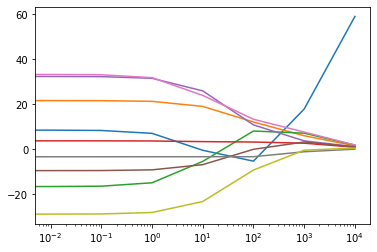

In [20]:
fg = plt.semilogx(alphas,ridgeBeta.T)

- The coefficients don't start to change until we get $\alpha > 1$ due to their size.  For large $\alpha$, we see all coefficients drop to zero exept for $\beta_0$ (the intercept term) which is not included in the ridge regression coefficient size penalty.
- We also don't see one coefficient preferentially dropped out compared to the others.  All of them tend to decrease proportional to their size.

- scikit uses an efficient form of leave-one-out cross validation to choose the best value of $\alpha$ from a range of choices we provide.

In [21]:
reg = linear_model.RidgeCV(alphas=alphas[1:])
reg.fit(x,y)
print('Best alpha: ',reg.alpha_)

Best alpha:  100.0


In [22]:
def CalcRidgeBeta(x,y):
    reg = linear_model.Ridge(alpha=100.0)
    reg.fit(x,y)
    beta = reg.coef_
    beta[0,0] = reg.intercept_[0]
    return beta.T
    
HoldoutCv(cvFrac = 0.3, nIter = 20, x=x, y=y, betaFunc=CalcRidgeBeta)

Iteration 0 - Train Var: 1406.57, CV Var: 1383.4
Iteration 1 - Train Var: 1316.09, CV Var: 1532.03
Iteration 2 - Train Var: 1364.37, CV Var: 1435.69
Iteration 3 - Train Var: 1378.97, CV Var: 1378.4
Iteration 4 - Train Var: 1339.61, CV Var: 1466.4
Iteration 5 - Train Var: 1367.72, CV Var: 1413.13
Iteration 6 - Train Var: 1339.23, CV Var: 1430.6
Iteration 7 - Train Var: 1377.96, CV Var: 1368.17
Iteration 8 - Train Var: 1371.05, CV Var: 1375.83
Iteration 9 - Train Var: 1391.37, CV Var: 1345.06
Iteration 10 - Train Var: 1332.71, CV Var: 1493.66
Iteration 11 - Train Var: 1340.26, CV Var: 1476.32
Iteration 12 - Train Var: 1385.99, CV Var: 1341.47
Iteration 13 - Train Var: 1361.17, CV Var: 1423.54
Iteration 14 - Train Var: 1362.39, CV Var: 1395.36
Iteration 15 - Train Var: 1416.03, CV Var: 1322.55
Iteration 16 - Train Var: 1391.27, CV Var: 1370.4
Iteration 17 - Train Var: 1382.31, CV Var: 1380.26
Iteration 18 - Train Var: 1458.38, CV Var: 1179.5
Iteration 19 - Train Var: 1383.76, CV Var: 1372

In [23]:
CalcRidgeBeta(x,y)

array([[-5.32843322],
       [12.04903125],
       [ 8.0494636 ],
       [ 3.16022675],
       [10.75126153],
       [-0.06629179],
       [13.27177142],
       [-3.35511372],
       [-9.27781564]])

In this case we can see that ridge regression has chosen a value of $\alpha$ that appears to minimize the overfitting.  We've really just returned to the performance we had before we created the higher order moments, though.

### Lasso
Lasso makes the apparently small modification of minimizing the sum of magnitude of the coefficients rather than the sum of squares but does a better job of forcing zero valued parameters.  This makes it better for model selection and reduction of redundant input variables.

In [24]:
alphas = [ 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4 ]
lassoBeta = np.zeros((p+1,len(alphas)))

j = 0
for alpha in alphas:
    reg = linear_model.Lasso(alpha=alpha)
    reg.fit(x,y[:,0])
    lassoBeta[0,j] = reg.intercept_
    lassoBeta[1:,j] = reg.coef_[1:]
    j += 1

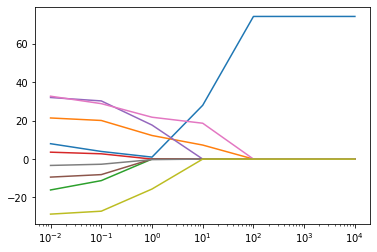

In [25]:
fig = plt.semilogx(alphas,lassoBeta.T)

- Lasso does a much better job of zeroing out parameters and producing a sparse model.

In [26]:
reg = linear_model.LassoCV(alphas=alphas)
reg.fit(x,y[:,0])
print('Best alpha: ',reg.alpha_)

Best alpha:  1.0


In [27]:
def CalcLassoBeta(x,y):
    reg = linear_model.Lasso(alpha=1.0)
    reg.fit(x,y)
    beta = reg.coef_ 
    beta[0] = reg.intercept_
    return np.array([beta]).T
    
HoldoutCv(cvFrac = 0.3, nIter = 20, x=x, y=y, betaFunc=CalcLassoBeta)

Iteration 0 - Train Var: 1342.92, CV Var: 1316.72
Iteration 1 - Train Var: 1300.38, CV Var: 1411.02
Iteration 2 - Train Var: 1293.74, CV Var: 1338.13
Iteration 3 - Train Var: 1336.27, CV Var: 1288.03
Iteration 4 - Train Var: 1314.65, CV Var: 1366.35
Iteration 5 - Train Var: 1354.19, CV Var: 1246.61
Iteration 6 - Train Var: 1315.47, CV Var: 1305.56
Iteration 7 - Train Var: 1319.98, CV Var: 1317.12
Iteration 8 - Train Var: 1340.8, CV Var: 1296.26
Iteration 9 - Train Var: 1222.83, CV Var: 1602.78
Iteration 10 - Train Var: 1276.03, CV Var: 1434.33
Iteration 11 - Train Var: 1310.64, CV Var: 1294.41
Iteration 12 - Train Var: 1305.48, CV Var: 1338.28
Iteration 13 - Train Var: 1368.18, CV Var: 1243.62
Iteration 14 - Train Var: 1361.59, CV Var: 1263.9
Iteration 15 - Train Var: 1363.79, CV Var: 1280.94
Iteration 16 - Train Var: 1280.1, CV Var: 1440.07
Iteration 17 - Train Var: 1332, CV Var: 1322.01
Iteration 18 - Train Var: 1357.44, CV Var: 1237.28
Iteration 19 - Train Var: 1302.97, CV Var: 1374

The performance looks pretty good.  Now, remove the elements from the model with low lasso parameters and see if traditional least squares on those features does as well.

In [28]:
betaBest = lassoBeta[:,2]
betaBest

array([  1.02394822,  12.27770865,   0.        ,   0.        ,
        17.71533353,  -0.        ,  21.79576727,  -0.28017739,
       -15.59254717])

- The input features are:
  - AvgOuts,AvgOnBase,AvgRuns,AvgRbis,AvgOuts$^2$,AvgOnBase$^2$,AvgRuns$^2$,AvgRbis$^2$
- Lasso selects: AvgOuts,AvgRbis,AvgOnBase$^2$,AvgRbis$^2$

In [29]:
m = len(players70.index)
p = 4

x = np.ones((m,p+1))
x[:,1] = players70[['AvgOuts']].to_numpy()[:,0]
x[:,2] = players70[['AvgRbis']].to_numpy()[:,0]
x[:,3] = players70[['AvgOnBase']].to_numpy()[:,0] **2
x[:,4] = players70[['AvgRbis']].to_numpy()[:,0] **2

In [30]:
nrm = np.ones((1,p+1))
nrm[0,1:] = np.sqrt(x[:,1:].var(axis=0))
x = x/nrm

In [31]:
HoldoutCv(cvFrac = 0.3, nIter = 20, x=x, y=y, betaFunc=CalcLsBeta)

Iteration 0 - Train Var: 1288.79, CV Var: 1329.27
Iteration 1 - Train Var: 1324.88, CV Var: 1252
Iteration 2 - Train Var: 1339.61, CV Var: 1207.45
Iteration 3 - Train Var: 1296.99, CV Var: 1298.9
Iteration 4 - Train Var: 1304.12, CV Var: 1268.89
Iteration 5 - Train Var: 1289.23, CV Var: 1326.9
Iteration 6 - Train Var: 1267.19, CV Var: 1384.93
Iteration 7 - Train Var: 1287.61, CV Var: 1334.18
Iteration 8 - Train Var: 1289.9, CV Var: 1330.29
Iteration 9 - Train Var: 1348.9, CV Var: 1188.03
Iteration 10 - Train Var: 1345.46, CV Var: 1199.75
Iteration 11 - Train Var: 1359.42, CV Var: 1161.98
Iteration 12 - Train Var: 1270.09, CV Var: 1402.55
Iteration 13 - Train Var: 1283.55, CV Var: 1348.02
Iteration 14 - Train Var: 1296.49, CV Var: 1319.13
Iteration 15 - Train Var: 1251.77, CV Var: 1424.97
Iteration 16 - Train Var: 1305.47, CV Var: 1291.06
Iteration 17 - Train Var: 1374.5, CV Var: 1136.24
Iteration 18 - Train Var: 1194.43, CV Var: 1553.55
Iteration 19 - Train Var: 1281.92, CV Var: 1348.2

So we see a slight improvement but we are still working with 4 features.  Let's try to prune the model more aggressively using the $\alpha$ = 10 parameters.

In [32]:
betaBest = lassoBeta[:,3]
betaBest

array([28.01622043,  7.30058409,  0.        ,  0.        ,  0.        ,
        0.        , 18.66578258, -0.        ,  0.        ])

- Lasso selects: AvgOuts,AvgOnBase$^2$

In [33]:
m = len(players70.index)
p = 2

x = np.ones((m,p+1))
x[:,1] = players70[['AvgOuts']].to_numpy()[:,0]
x[:,2] = players70[['AvgOnBase']].to_numpy()[:,0] **2

In [34]:
nrm = np.ones((1,p+1))
nrm[0,1:] = np.sqrt(x[:,1:].var(axis=0))
x = x/nrm

In [35]:
HoldoutCv(cvFrac = 0.3, nIter = 20, x=x, y=y, betaFunc=CalcLsBeta)

Iteration 0 - Train Var: 1490.55, CV Var: 1227.62
Iteration 1 - Train Var: 1449.34, CV Var: 1348.91
Iteration 2 - Train Var: 1401.81, CV Var: 1454.89
Iteration 3 - Train Var: 1519.06, CV Var: 1180.36
Iteration 4 - Train Var: 1432.22, CV Var: 1384.65
Iteration 5 - Train Var: 1401.82, CV Var: 1456.88
Iteration 6 - Train Var: 1322.58, CV Var: 1632.23
Iteration 7 - Train Var: 1321.43, CV Var: 1645.91
Iteration 8 - Train Var: 1459.93, CV Var: 1323.64
Iteration 9 - Train Var: 1476.77, CV Var: 1281.31
Iteration 10 - Train Var: 1366.14, CV Var: 1547.26
Iteration 11 - Train Var: 1382.56, CV Var: 1506.72
Iteration 12 - Train Var: 1458.93, CV Var: 1318.71
Iteration 13 - Train Var: 1458.43, CV Var: 1332.55
Iteration 14 - Train Var: 1402.14, CV Var: 1449.73
Iteration 15 - Train Var: 1429.33, CV Var: 1398.32
Iteration 16 - Train Var: 1451.44, CV Var: 1312.19
Iteration 17 - Train Var: 1419.21, CV Var: 1406.64
Iteration 18 - Train Var: 1414.65, CV Var: 1432.09
Iteration 19 - Train Var: 1405.43, CV Var

Now we're getting similar performance to the original model but with only *two* input data features!

## Notes

- This section includes some notes related to Chapter 3 of [Elements of Statistical Learning](https://web.stanford.edu/~hastie/Papers/ESLII.pdf).

#### Introduction
- The training data can be represented by a $\mathbb{X} \in \mathcal{R}^{M\times P}$ matrix where $M$ is the number of training samples and $P$ is the number of features in the data.  The $m$th row is $\mathbb{x}_m = [\ x_{m1},\ldots x_{mP}\ ]$ and the $p$th column is $\mathbb{X}_p$.
- A note on the features:
  - We have $N \leq P$ actual features in the data.
  - The remaining features can be created by taking higher order *basis expansions* of the original features.
  - If we have qualitative data (ie. player position), we can include this data by "dummy coding" it where each value is represented by a different feature and each feature is equal to $\{0,1\}$ depending on if it is true or false.
  
- The hypothesis function is $h(\mathbb{x}_m) = \mathbb{\beta} \mathbb{x_m}^T$ where $\mathbb{\beta} = [\ \beta_0\ \ldots\ \beta_P\ ]$.
- The residual sum of squares, RSS$(\mathbb{\beta})$, is the squared difference between the hypothesis function output and the actual target variable values summed over the $M$ training samples.
- We can solve for the parameters that minimize RSS directly using the pseudo-inverse (least squares projection) of the entire $\mathbb{X}$ matrix.  This works even if $\mathbb{X}$ isn't full rank (some of the columns are linearly dependent on others).
- The matrix inverse can be avoided by minimizing RSS using gradient descent or Newton's method.

#### Data Distribution & Model Statistics
- Assume that $h(\mathbb{X})$ is the true model for the mean of the target variable data $\mathbb{Y}$ and that any deviation about that mean observed in the data is Gaussian distributed so that $\mathbb{Y} = h(\mathbb{X}) + \epsilon$ and $\epsilon$ is a Gaussian random variable.
- The estimated model parameters are Gaussian distributed and the estimated target variable variance is Chi squared distributed.

- These assumptions allow us to evaluate confidence in the model parameters.
- The model parameters can be normalized by their standard deviations to create a Z-score to for use in a statistical confidence calculation:
  - A good discussion of statistical inference and the null hypothesis can be found in Chapter 7 of [Campbell, et.al.](https://ucalgary-primo.hosted.exlibrisgroup.com/permalink/f/12m0b6n/01UCALG_ALMA51675036160004336).
  - The *null hypothesis* is often used since it's easier to disprove.  For example, a hypothesis could be "All Asian children have black hair." which is hard to prove since all Asian children would need to be observed.  However, the hypothesis is much easier to disprove.  The null hypothesis is "There is at least one Asian child who does not have black hair." which is easier to prove since there is a chance we could prove this by observing just one child.
  - Our hypothesis is that a data feature has influence over the target variable and its corresponding parameter is non-zero in order to reflect that influence.  The null hypothesis is that the parameter is equal to zero.
  - No parameter will be truly equal to zero and our task is to determine whether a non-zero value of $\beta$ is simply due to random variation.  
  - A $p$-value corresponds to the probability that we discard a statistically significant model parameter as null.  Typically, $p < 0.05$.  We can use the t-distribution to determine the threshold below which random variations in a zero mean parameter would fall $1-p$ percent of the time.  
  - If the Z-score for our parameter is larger than this threshold, we assume that the null hypothesis is false, that we can have confidence that our model parameter is statistically significant and that it should be retained in our model.
- The F-statistic can be used to determine whether a group of parameters can be dropped from the model.  Useful for when a categorical variable is represented by a group of dummy indicator function variables.
- 95% confidence intervals for each model parameter can also be calculated either individually or as a group (individual is probably best).

#### Gauss-Markov Theory
- Start by assuming a linear combination of the parameters $\mathbb{x}_0^T\mathbb{\beta}$.  In this case, the data vector $\mathbb{x}_0$ is fixed.  Our calculation of the linear combination $\hat{\mathbb{\theta}} = \mathbb{x}_0^T\hat{\mathbb{\beta}}$ is an approximation since we're working with estimated values of the real underlying parameters.
- These parameter estimates are generated from $\mathbb{X}$, which we also assume is fixed.
- The model is unbiased since the mean of the estimate equals the true values.  The theorem says the pseudo-inverse solution to the estimated parameters gives the minimum variance unbiased estimator.

- While the theorem says least squares has the minimum MSE of all unbiased estimators, there may be another estimator with lower MSE that *has bias*.
- Bias can be caused by shrinking or zeroing out least squares coefficients.

#### Subset Selection
- This is where we shrink parameters and/or remove variables to improve prediction accuracy (lowering prediction error by introducing bias) and make the model easier to understand by focusing on the most important variables.
- Subset selection retains only a subset of the variables.
- Easy to understand but there are criticisms of this method as being too chunky and/or relying on inaccurate statistics.

#### Shrinkage Methods
- Adds an extra penalty in the minimization to reduce the sum of squares of the model coefficients.  Shrinks the coefficients towards zero and each other.
- Tends to eliminate large negative coefficients balanced by large positive coefficients which tends to occur when input variables are correlated.
- Inputs need to be standardized (normalize to unit variance) and centered (means subtracted off).  The y-intercept parameter ($\beta_0$) is not included in the penalty and is estimated by setting it equal to the mean of the target variable.
- The model parameters can again be solved directly using the least squares solution (and likely gradient descent or Newton's method).
- An SVD analysis demonstrates that ridge regression tends to shrink components that do not correspond to a large amount of variance in the target variable.  Likely because there is not a lot of statistical correlation.
- Lasso has the nice feature that it keeps some variables right at zero but requires a quadratic programming solution.
- LAR is a simpler approach that results in almost the same performance as Lasso.